In [145]:
import sys, os
import math, random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

from PIL import Image
import matplotlib.pyplot as plt

## Loading the dataset + setting the labels

In [2]:
class_labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
                'bus', 'car', 'cat', 'chair', 'cow',
                'diningtable', 'dog', 'horse', 'motorbike', 'person',
                'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [3]:
class transformLabel(object):

    def __init__(self, classes):
        self.classes = classes

    def __call__(self, metadata, num_classes=20):
        label = torch.zeros(num_classes)
        for obj in metadata['annotation']['object']:
            label[self.classes.index(obj['name'])] = 1

        return label


In [168]:
mean_vals = [0.4181, 0.4184, 0.4185]

transformTrain = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter((0.6, 1.4), (0.6, 1.4), (0.6, 1.4), (-0.1, 0.1)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomGrayscale(0.2),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, [1,1,1])
]
)

transformVal = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, [1,1,1])
]
)

In [169]:
VOC_train = datasets.VOCDetection('data/trainval/', 
                                year='2012', 
                                image_set='train', 
                                download=False, 
                                transform=transformTrain,
                                target_transform=transformLabel(class_labels),
                                )


VOC_val = datasets.VOCDetection('data/trainval/', 
                                year='2012', 
                                image_set='val', 
                                download=False, 
                                transform=transformVal,
                                target_transform=transformLabel(class_labels)
                                )

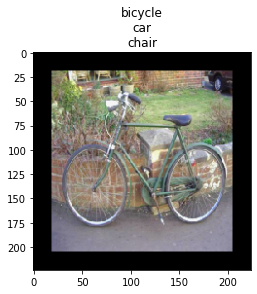

In [175]:
img_, lbl_ = VOC_train[random.randint(0, len(VOC_train))]

lbl = torch.where(lbl_==1)[0]
label = ""
for idx, num in enumerate(lbl):
    if idx!=0:
        label += "\n"
    label += class_labels[int(num)]

plt.figure()
plt.imshow(img_.permute(1,2,0) + torch.tensor(mean_vals))
plt.title(label)
plt.show()

## Building architecture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


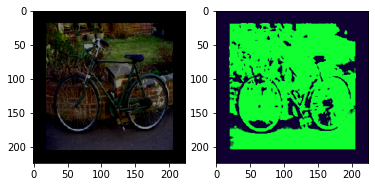

In [176]:
# checking seperable convolutions...
n = 3
conv = nn.Conv2d(n, n, kernel_size=3, padding=1, groups=n,)
conv.weight.requires_grad=False
conv.weight[0,:,:,:] = torch.nn.Parameter(0*torch.ones((1,3,3)))
conv.weight[1,:,:,:] = torch.nn.Parameter(5*torch.ones((1,3,3)))
conv.weight[2,:,:,:] = torch.nn.Parameter(0*torch.ones((1,3,3)))


img_convd = conv(img_)
plt.subplot(121)
plt.imshow(np.transpose(img_,(1,2,0)))
plt.subplot(122)
plt.imshow(np.transpose(img_convd.detach().numpy(),(1,2,0)))

In [182]:
A = torch.tensor([[1,2,3,5],[4,5,6,5],[3,2,1,5]])
B = torch.tensor([[2],[3],[1]])

(B*A).shape, (A*B).shape

(torch.Size([3, 4]), torch.Size([3, 4]))

Squeeze and excitation layer intuitions: https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7

Seperable convolution block: https://arxiv.org/abs/2204.01697

Transformer encoder: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder

In [285]:
class SqueezeExcite(nn.Module): 

    def __init__(self, c_in, r=2):
        
        super().__init__()

        c_mid = round(c_in/r)
        self.squeeze = nn.Linear(c_in, c_mid)
        self.excite = nn.Linear(c_mid, c_in)

    def forward(self, x):

        x_in = x

        x = torch.mean(torch.flatten(x, -2, -1), dim=-1) # GAP
        x = torch.relu(self.squeeze(x))
        x = torch.sigmoid(self.excite(x))
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = x_in*(x + 1)

        return x


class SepBlock(nn.Module): # similar to MBConv block found in max-vit!

    def __init__(self, c_in=3, c_out=3, res=False, project=False, SE=False, reduce=False):

        super().__init__()
            
        self.res = res
        self.SE = SE
        self.reduce = reduce
        self.project = False if c_in == c_out else True

        depth_stride=2 if reduce else 1

        self.conv_depth = nn.Conv2d(c_in, c_in, kernel_size=3, stride=depth_stride, padding=1, groups=c_in)
        self.conv_point = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0, groups=1) 
        self.conv_project = nn.Conv2d(c_in, c_out, kernel_size=1, padding=0, groups=1) 
        self.squeeze_excite = SqueezeExcite(c_in)

    def forward(self, x):

        x_in = x
        x = self.conv_point(x)                                          # 1x1 pointwise
        x = torch.relu(self.conv_depth(x))                              # 3x3 depthwise
        x = self.squeeze_excite(x) if self.SE else x                    # squeeze-excitation
        x = torch.relu(self.conv_point(x))                              # 1x1 pointwise
        x = torch.relu(x)

        if self.res:
            x_in = torch.max_pool2d(x_in, 2) if self.reduce else x_in
            x = x + x_in                                                # residual
            
        x = torch.relu(self.conv_project(x)) if self.project else x     # project to another dimension

        return x



In [286]:
A = torch.rand(size=(32, 3, 56, 56))

sep = SepBlock(c_in=3, c_out=6, res=True, SE=True, reduce=True)
B = sep(A)

A.shape, B.shape

(torch.Size([32, 3, 56, 56]), torch.Size([32, 6, 28, 28]))

In [290]:
class SepNet(nn.Module):

    def __init__(self, c0=3, c1=32, c2=64, SC_blocks=6):
        super().__init__()
        
        self.c0 = c0
        self.c1 = c1
        self.c2 = c2

        self.conv1 = nn.Conv2d(c0, c1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)

        # add 6 SepBlocks, reducing and projecting to higher-D alternatively. 56x56x64 --> 7x7x512
        c_ins = [64, 64, 128, 128, 256, 256]
        c_outs = [64, 128, 128, 256, 256, 512]

        SC_list = []
        for i in range(SC_blocks):
            (red, proj) = (True, True) if i % 2 != 0 else (False, False)
            SC_list.append(SepBlock(c_in=c_ins[i], c_out=c_outs[i], res=True, SE=True, reduce=red))

        self.SClayers = nn.Sequential(*SC_list)

        self.ViTlayer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)

    def forward(self, x):
        x_in = x
        x = torch.max_pool2d(torch.relu(self.conv1(x)), 2)
        x = torch.max_pool2d(torch.relu(self.conv2(x)), 2)

        x = self.SClayers(x)

        print(x.shape)

        x = torch.flatten(x, -2, -1)
        print(x.shape)


        return x


In [291]:
A = torch.rand(size=(32, 3, 224, 224))

net = SepNet()
B = net(A)

A.shape, B.shape

# forward pass time around 0.5s per image....

torch.Size([32, 512, 7, 7])
torch.Size([32, 512, 49])


(torch.Size([32, 3, 224, 224]), torch.Size([32, 512, 49]))